## Setup

### Import packages

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline

from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from sklearn.externals import joblib

from wordcloud import WordCloud
from matplotlib import pyplot as plt

import lime
import lime.lime_tabular

/anaconda3/envs/LP-NLP/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/anaconda3/envs/LP-NLP/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Load data

In [2]:
df = pd.read_csv("spam.csv", encoding="L1")
df = df.rename(
    columns = {
        "v1": "label",
        "v2": "text"
    }
)

df = df[["label", "text"]]

labels = df["label"].values
text = df["text"].values

### Build visualization functions

In [3]:
def make_word_cloud(words_array):
    
    """
    Takes an array of text and makes a word cloud from it.
    """
    
    words_str = " ".join([c.lower() for c in words_array])
    wordcloud = WordCloud().generate(words_str)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
    return

def word_cloud_from_df(df, label):
    
    """
    Takes a DataFrame with columns labels and text.
    Visualizes all the text for a label as a word cloud.
    """
    
    words_array = df.loc[df["label"]==label, "text"].values
    make_word_cloud(words_array)
    
    return

### Build other functions and classes

In [4]:
class DenseTransformer(TransformerMixin):
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        return X.todense()        

## Visualize the data

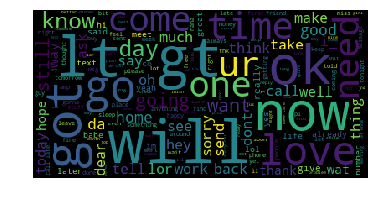

In [5]:
word_cloud_from_df(df, "ham")

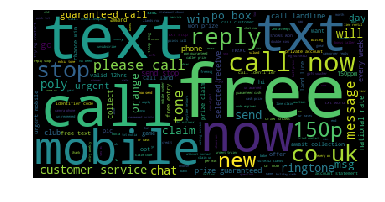

In [6]:
word_cloud_from_df(df, "spam")

## Process the data for learning

In [7]:
X = text
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Word counts as features

### Naive Bayes

In [8]:
# note: CountVectorizer returns a sparse matrix, while GaussianNB requires a dense matrix
cv_nb = Pipeline([
    ("count_vectorizer", CountVectorizer()),
    ("dense_transformer",  DenseTransformer()),
    ("naive_bayes", GaussianNB())
])

In [9]:
%%time
cv_nb.fit(X_train, y_train)

CPU times: user 1.62 s, sys: 357 ms, total: 1.97 s
Wall time: 943 ms


Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...mer', <__main__.DenseTransformer object at 0x1a1ac37828>), ('naive_bayes', GaussianNB(priors=None))])

In [10]:
cv_nb_train_acc = cv_nb.score(X_train, y_train)
cv_nb_test_acc = cv_nb.score(X_test, y_test)

print(f"Word Count - Naive Bayes Train Accuracy {cv_nb_train_acc}")
print(f"Word Count - Naive Bayes Test Accuracy {cv_nb_test_acc}")

Word Count - Naive Bayes Train Accuracy 0.9552524527398899
Word Count - Naive Bayes Test Accuracy 0.8987796123474515


### Ada Boost

In [11]:
# note: AdaBoostClassifier() does not require a dense matrix and runs significantly faster with a sparse matrix
cv_ab = Pipeline([
    ("count_vectorizer", CountVectorizer()),
    ("ada_boost", AdaBoostClassifier())
])

In [12]:
%%time
cv_ab.fit(X_train, y_train)

CPU times: user 704 ms, sys: 10.5 ms, total: 715 ms
Wall time: 413 ms


Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...m='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])

In [13]:
cv_ab_train_acc = cv_ab.score(X_train, y_train)
cv_ab_test_acc = cv_ab.score(X_test, y_test)

print(f"Word Count - Ada Boost Train Accuracy {cv_ab_train_acc}")
print(f"Word Count - Ada Boost Test Accuracy {cv_ab_test_acc}")

Word Count - Ada Boost Train Accuracy 0.9813352476669059
Word Count - Ada Boost Test Accuracy 0.9727207465900933


## TF-IDF as Features

### Naive Bayes

In [14]:
# note: CountVectorizer -> TfidfTransformer returns a sparse matrix, while GaussianNB requires a dense matrix
tfidf_nb = Pipeline([
    ("count_vectorizer", CountVectorizer()),
    ("tfidf_transformer",  TfidfTransformer()),
    ("dense_transformer",  DenseTransformer()),
    ("naive_bayes", GaussianNB())
])

In [15]:
%%time
tfidf_nb.fit(X_train, y_train)

CPU times: user 1.37 s, sys: 364 ms, total: 1.73 s
Wall time: 896 ms


Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...mer', <__main__.DenseTransformer object at 0x1a1b4c20b8>), ('naive_bayes', GaussianNB(priors=None))])

In [16]:
tfidf_nb_train_acc = tfidf_nb.score(X_train, y_train)
tfidf_nb_test_acc = tfidf_nb.score(X_test, y_test)

print(f"TF-IDF - Naive Bayes Train Accuracy {tfidf_nb_train_acc}")
print(f"TF-IDF - Naive Bayes Test Accuracy {tfidf_nb_test_acc}")

TF-IDF - Naive Bayes Train Accuracy 0.9552524527398899
TF-IDF - Naive Bayes Test Accuracy 0.8951902368987796


### Ada Boost

In [17]:
# note: AdaBoostClassifier() does not require a dense matrix and runs significantly faster with a sparse matrix
tfidf_ab = Pipeline([
    ("count_vectorizer", CountVectorizer()),
    ("tfidf_transformer",  TfidfTransformer()),
    ("ada_boost", AdaBoostClassifier())
])

In [18]:
%%time
tfidf_ab.fit(X_train, y_train)

CPU times: user 860 ms, sys: 9.6 ms, total: 869 ms
Wall time: 551 ms


Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...m='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])

In [19]:
tfidf_ab_train_acc = tfidf_ab.score(X_train, y_train)
tfidf_ab_test_acc = tfidf_ab.score(X_test, y_test)

print(f"TF-IDF - Ada Boost Train Accuracy {tfidf_ab_train_acc}")
print(f"TF-IDF - Ada Boost Test Accuracy {tfidf_ab_test_acc}")

TF-IDF - Ada Boost Train Accuracy 0.9834888729361091
TF-IDF - Ada Boost Test Accuracy 0.9691313711414213


## Cross Validation

`cross_validate` will give consistent splits without specifying a splitter, but, I use a splitter because I want to shuffle the data for cross validation.

In [20]:
models = {
    "Word Count Naive Bayes": cv_nb,
    "Word Count Ada Boost": cv_ab,
    "TF-IDF Naive Bayes": tfidf_nb,
    "TF-IDF Ada Boost": tfidf_ab
}



kf = KFold(n_splits=6, shuffle=True, random_state=66)

for key in models:

    scores = cross_validate(models[key], X, y, cv=kf)
    print(key)
    print("fit_time", scores["fit_time"])
    print("test_score", scores["test_score"])
    print()

Word Count Naive Bayes
fit_time [1.07478905 1.06247187 1.02332115 1.06461382 1.06879807 1.05293202]
test_score [0.91496233 0.90527449 0.90635091 0.8977395  0.91271552 0.89116379]

Word Count Ada Boost
fit_time [0.44997716 0.47795606 0.42090082 0.42685723 0.4202292  0.42175984]
test_score [0.97739505 0.97308934 0.97631862 0.96340151 0.96767241 0.98060345]

TF-IDF Naive Bayes
fit_time [1.05396008 0.99535298 0.98422813 0.9894619  1.00477791 1.02478623]
test_score [0.90850377 0.90204521 0.89989236 0.89558665 0.91056034 0.89008621]

TF-IDF Ada Boost
fit_time [0.63250208 0.58125997 0.58323908 0.5776403  0.58493423 0.58274293]
test_score [0.97739505 0.97739505 0.96555436 0.97201292 0.96443966 0.97737069]



## Retrain with all data


We'll go with Word Count Ada Boost because its preformance is esentially tied with TF-IDF Ada boost.

In [21]:
cv_ab.fit(X, y)

Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...m='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])

## Prediction

We'll go with Word Count Ada Boost because its preformance is esentially tied with TF-IDF Ada boost.

In [22]:
cv_ab.predict(["This is ham!"])

array(['ham'], dtype=object)

In [23]:
cv_ab.predict(["XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here"])

array(['spam'], dtype=object)

## Explanation (Local Interpretability of Logistic Regression)

In order to be able to explain anything, we'll have to break open the pipline.

### Process the text data into features array

In [24]:
X_words = X

cv = CountVectorizer()
cv.fit(X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

### Prepare the data for lime

In [25]:
# lime LimeTabularExplainer an array as its input
X_mat_sparse = cv.transform(X)
X_array = X_mat_sparse.toarray()

# I get the feature names in alphabetical order
feature_names = pd.Series(cv.vocabulary_).sort_values().index.values

# Lime need to have the array in the same order assign the right labels
X_df = pd.DataFrame(X_array)
X_df = X_df[X_df.columns.sort_values()]
X_array = X_df.values

### Train the model on the features array

In [26]:
# Use logistic regression as an example, because Ada-Boost is a tree method does not what classification probabiltes
lr = LogisticRegression()
lr.fit(X_array, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Initialize the explainer

In [27]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    np.array(X_array),
    feature_names=list(feature_names),
    class_names=np.array(['ham', 'spam']),
    discretize_continuous=True
)

/anaconda3/envs/LP-NLP/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Explain a spam observation

In [28]:
#i = np.random.randint(0, X_array.shape[0])
i = 2824
i_text = X[i]
i_label = y[i]
i_predicted = lr.predict([X_array[i]])
i_predicted_probability = lr.predict_proba([X_array[i]])[0]
print(f"Observation index: {i} \n")
print(f"Observation text: {i_text} \n")
print(f"Observation (true) label: {i_label} \n")
print(f"Observation prediction: {i_predicted} \n")
print(f"Observation predicted probability: {i_predicted_probability}")

Observation index: 2824 

Observation text: Congratulations - Thanks to a good friend U have WON the å£2,000 Xmas prize. 2 claim is easy, just call 08712103738 NOW! Only 10p per minute. BT-national-rate 

Observation (true) label: spam 

Observation prediction: ['spam'] 

Observation predicted probability: [0.00407186 0.99592814]


In [29]:
exp = explainer.explain_instance(X_array[i], lr.predict_proba, num_features=5, num_samples=5000)

In [30]:
%%time
exp.show_in_notebook(show_table=True, show_all=False)

CPU times: user 333 ms, sys: 12.6 ms, total: 345 ms
Wall time: 112 ms


### Explain a ham observation

In [31]:
#i = np.random.randint(0, X_array.shape[0])
i = 3006
i_text = X[i]
i_label = y[i]
i_predicted = lr.predict([X_array[i]])
i_predicted_probability = lr.predict_proba([X_array[i]])[0]
print(f"Observation index: {i} \n")
print(f"Observation text: {i_text} \n")
print(f"Observation (true) label: {i_label} \n")
print(f"Observation prediction: {i_predicted} \n")
print(f"Observation predicted probability: {i_predicted_probability}")

Observation index: 3006 

Observation text: Ah you see. You have to be in the lingo. I will let you know wot on earth it is when has finished making it! 

Observation (true) label: ham 

Observation prediction: ['ham'] 

Observation predicted probability: [0.98912091 0.01087909]


In [32]:
exp = explainer.explain_instance(X_array[i], lr.predict_proba, num_features=5, num_samples=5000)

In [33]:
%%time
exp.show_in_notebook(show_table=True, show_all=False)

CPU times: user 174 ms, sys: 14.8 ms, total: 188 ms
Wall time: 55.6 ms


### Explain a low conficence observation

In [43]:
#i = np.random.randint(0, X_array.shape[0])
i = 2662
i_text = X[i]
i_label = y[i]
i_predicted = lr.predict([X_array[i]])
i_predicted_probability = lr.predict_proba([X_array[i]])[0]
print(f"Observation index: {i} \n")
print(f"Observation text: {i_text} \n")
print(f"Observation (true) label: {i_label} \n")
print(f"Observation prediction: {i_predicted} \n")
print(f"Observation predicted probability: {i_predicted_probability}")

Observation index: 2662 

Observation text: Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy? 

Observation (true) label: spam 

Observation prediction: ['ham'] 

Observation predicted probability: [0.52896177 0.47103823]


In [44]:
exp = explainer.explain_instance(X_array[i], lr.predict_proba, num_features=5, num_samples=5000)

In [45]:
%%time
exp.show_in_notebook(show_table=True, show_all=False)

CPU times: user 181 ms, sys: 16.1 ms, total: 198 ms
Wall time: 59.9 ms


In [48]:
exp.as_html()

'<html>\n        <meta http-equiv="content-type" content="text/html; charset=UTF8">\n        <head><script>var lime =\n/******/ (function(modules) { // webpackBootstrap\n/******/ \t// The module cache\n/******/ \tvar installedModules = {};\n/******/\n/******/ \t// The require function\n/******/ \tfunction __webpack_require__(moduleId) {\n/******/\n/******/ \t\t// Check if module is in cache\n/******/ \t\tif(installedModules[moduleId])\n/******/ \t\t\treturn installedModules[moduleId].exports;\n/******/\n/******/ \t\t// Create a new module (and put it into the cache)\n/******/ \t\tvar module = installedModules[moduleId] = {\n/******/ \t\t\texports: {},\n/******/ \t\t\tid: moduleId,\n/******/ \t\t\tloaded: false\n/******/ \t\t};\n/******/\n/******/ \t\t// Execute the module function\n/******/ \t\tmodules[moduleId].call(module.exports, module, module.exports, __webpack_require__);\n/******/\n/******/ \t\t// Flag the module as loaded\n/******/ \t\tmodule.loaded = true;\n/******/\n/******/ 

## Export

In [38]:
joblib.dump(cv_ab, "spam_detector.pkl")

['spam_detector.pkl']